In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
import pandas as pd
import pystan

import os
import pickle

import omnitool
from omnitool import spyglass

import sys
%pylab inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
def read_trilegal():
    tdf = pd.read_csv('../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep='\s+')
    tdf['Ak'] = omnitool.literature_values.Av_coeffs['Ks'].values[0]*tdf.Av
    tdf['MK'] = tdf.Ks - tdf['m-M0'] - tdf.Ak
    tdf['dist'] = 10.0**(tdf['m-M0'] / 5.0 + 1.0)
    tdf['parallax'] = 1./tdf.dist
    return tdf[tdf.stage==5]  

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [ ]:
# df = read_data()
df = read_trilegal()
df.head(2)
print('Size: '+str(len(df)))

Before: 45597
After: 4876
Before: 45597
After: 2192
Before: 2192
After: 752
-1.4864999999999995


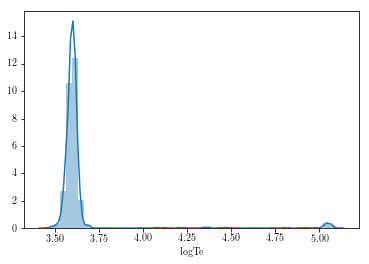

In [23]:
#Instead of using this generated data, lets run straight on the TRILEGAL sample!
sfile = '/home/oliver/PhD/Hacks_and_Mocks/PyStanExamples/Oli/file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V

#Make some cuts
L = (10**df.logL)*Lsol
T = 10**df.logTe
df['R'] = np.sqrt(L/(4*np.pi*stefboltz*T**4))/Rsol
print('Before: '+str(len(df)))
wddf = df.loc[df.R < .5]
wddf[wddf.logTe > 4.]
print('After: '+str(len(wddf)))

#Make some cuts
print('Before: '+str(len(df)))
gdf = df.loc[np.abs(df.BV - 0.9) < 0.6]
gdf = gdf.loc[gdf.K > 8.0]
gdf = gdf.loc[gdf.logg < 3.5]
print('After: '+str(len(gdf)))

#Calculate absolute magnitude (no extinction)
gdf['MK'] = gdf.K - 5.0 * np.log10(gdf.dist) + 5.0

#Make some cuts and add on the data
print('Before: '+str(len(gdf)))
rcdf = gdf[np.abs(gdf.MK --1.5) < .4]
# df = df.append([df, df, df, df])#df, df, df, df, df])
print('After: '+str(len(rcdf)))
print(np.median(rcdf.MK))

sns.distplot(wddf.logTe)

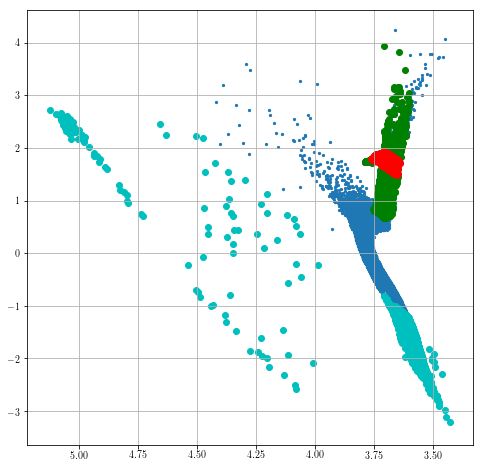

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df.logTe,df.logL,s=5)
ax.scatter(gdf.logTe,gdf.logL,c='g')
ax.scatter(rcdf.logTe, rcdf.logL,c='r')
ax.scatter(wddf.logTe, wddf.logL,c='c')
ax.invert_xaxis()
ax.grid()
plt.show()

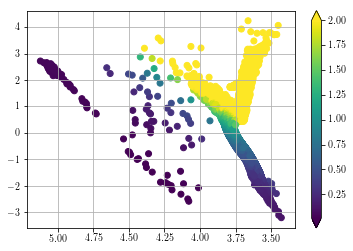

0.0001


In [70]:
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(df.dist,label='Full')
sns.distplot(gdf.dist,label='Giants')
sns.distplot(rcdf.dist,label='RC')
sns.distplot(wddf.dist,label='WDs')
ax.legend()
plt.show

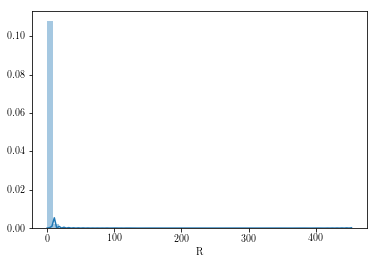

In [64]:
sns.distplot(df.R[np.isfinite(df.R)])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45597 entries, 0 to 45596
Data columns (total 23 columns):
#Gc       45597 non-null object
logAge    45597 non-null object
[M/H]     45597 non-null object
m_ini     45596 non-null float64
logL      45596 non-null float64
logTe     45596 non-null float64
logg      45596 non-null float64
m-M0      45596 non-null float64
Av        45596 non-null float64
m2/m1     45596 non-null float64
mbol      45596 non-null float64
U         45596 non-null float64
B         45596 non-null float64
V         45596 non-null float64
R         45596 non-null float64
I         45596 non-null float64
J         45596 non-null float64
H         45596 non-null float64
K         45596 non-null float64
Mact      45596 non-null float64
dist      45596 non-null float64
par       45596 non-null float64
BV        45596 non-null float64
dtypes: float64(20), object(3)
memory usage: 8.0+ MB


In [18]:
import pickle
sm = pickle.load(open('../data/stanmodels/asterostan.pkl', 'rb'))

In [19]:
dat = {'N': len(d),
      'Mi': d,
      'Mi_err' : err}

fit = sm.sampling(data=dat, iter=3000, chains=1)

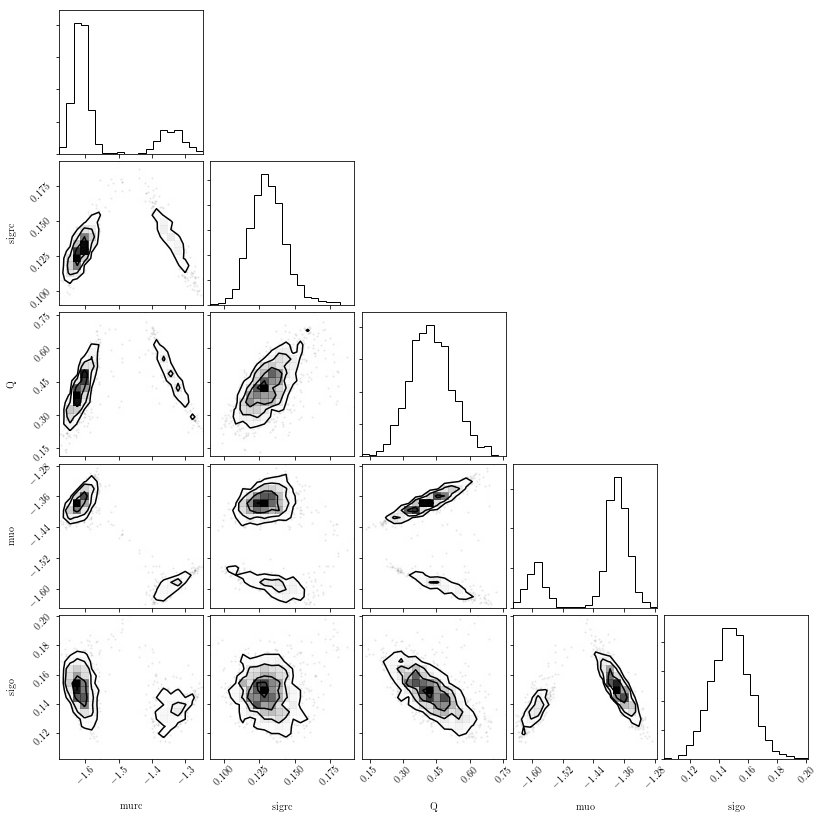

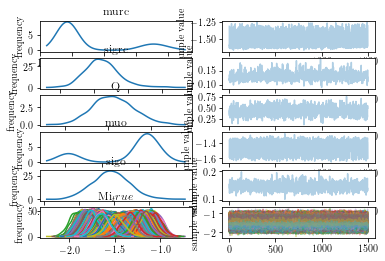

In [20]:
import corner
trace = fit.extract()
chain = np.array([trace['murc'],trace['sigrc'],trace['Q'],trace['muo'],trace['sigo']])
corner.corner(chain.T,labels=['murc','sigrc','Q','muo','sigo'])
plt.show()
fit.plot(pars=['murc','sigrc','Q','muo','sigo','Mi_true'])
plt.show()

In [24]:
murc = np.median(trace['murc'])
sigrc = np.median(trace['sigrc'])
muo = np.median(trace['muo'])
sigo = np.median(trace['sigo'])
Q = np.median(trace['Q'])
tpp = trace['post_prob']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]

fg = normal(d, murc, sigrc)
bg = normal(d, muo, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

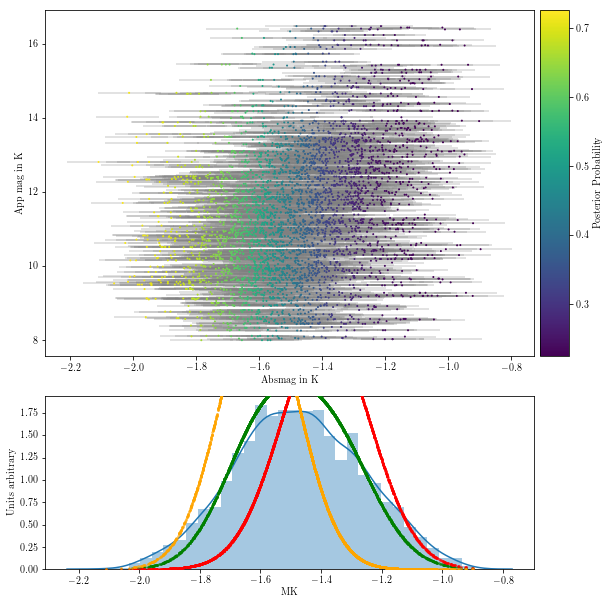

In [25]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(d,df.K.values,s=1,c=post_prob,zorder=1000)
fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(d,df.K.values,xerr=err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(d,ax=xax)

xax.scatter(d,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(d,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(d, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

## Old Testing Code

In [ ]:
#Instead of using this generated data, lets run straight on the TRILEGAL sample!
sfile = '/home/oliver/PhD/Hacks_and_Mocks/PyStanExamples/Oli/file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V

#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]

#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
df['MH'] = df.J - 5.0 * np.log10(df.dist) + 5.0

#Add error
err = np.ones(len(df.MK))*.1
d = df.MK + np.random.randn(len(df))*err
dh = df.MH + np.random.randn(len(df))*err

#Plotting
fig, ax = plt.subplots(2,2,figsize=(8,8))
sns.distplot(d, ax=ax[0,0])
sns.distplot(dh, ax=ax[0,1])
ax[1,0].scatter(d,df.K,s=4)
ax[1,0].errorbar(d,df.K,xerr=err,fmt='none',c='grey',alpha=.3)
ax[1,1].scatter(dh,df.H,s=4)
ax[1,1].errorbar(dh,df.H,xerr=err,fmt='none',c='grey',alpha=.3)
plt.show()
print(len(d))

In [ ]:
code = '''
functions {
    real logposexp(real x, real c0, real c1, real lambd) {
        return log(lambd/(c1^(lambd)-c0^(lambd))) + lambd*x;
    }
}
data {
    int<lower = 0> N;
    real d[N];
    real err[N];
    real c0;
    real c1;
}
parameters {
    real lambd;
    real mu;
    real <lower=0.> sig;
    real <lower=0.,upper=1.> Q;
    real d_true[N];
}
model {
    d_true ~ normal(d, err);

    lambd ~ normal(0.2,0.1);
    mu ~ normal(-3.,1.);
    sig ~ normal(1.,0.1);
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(d_true[n] | mu, sig),
            logposexp(d_true[n] ,c0, c1, lambd));
}
generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(d[n] | mu, sig);
        ll_bg = log(1-Q) + logposexp(d[n], c0, c1, lambd);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

In [ ]:
#Run in K
dat = {'N': len(d),
      'd': d,
      'err' : err,
      'c0' : np.exp(np.nanmin(d)),
      'c1' : np.exp(np.nanmax(d))}
fit = sm.sampling(data=dat, iter=3000, chains=1)

In [ ]:
import corner
trace = fit.extract()
chain = np.array([trace['mu'],trace['sig'],trace['Q'],trace['lambd']])
corner.corner(chain.T,labels=['mu','sig','Q','lambd'])
plt.show()
fit.plot(pars=['mu','sig','Q','lambd','d_true'])
plt.show()

In [ ]:
Klambd = np.median(trace['lambd'])
Kmu = np.median(trace['mu'])
Kmustd = np.std(trace['mu'])
Ksig = np.median(trace['sig'])
KQ = np.median(trace['Q'])
Ktpp = trace['post_prob']
K_post_prob = np.sum(Ktpp,axis=0)/Ktpp.shape[0]

Kbg = logposexp(d, Klambd)
Kfg = normal(d, Kmu, Ksig)
KL = KQ*Kfg + (1-KQ)*Kbg

In [ ]:
#Run in H
dat = {'N': len(dh),
      'd': dh,
      'err' : err,
      'c0' : np.exp(np.nanmin(dh)),
      'c1' : np.exp(np.nanmax(dh))}
fit = sm.sampling(data=dat, iter=3000, chains=1)

In [ ]:
import corner
trace = fit.extract()
chain = np.array([trace['mu'],trace['sig'],trace['Q'],trace['lambd']])
corner.corner(chain.T,labels=['mu','sig','Q','lambd'])
plt.show()
fit.plot(pars=['mu','sig','Q','lambd','d_true'])
plt.show()

In [ ]:
Hlambd = np.median(trace['lambd'])
Hmu = np.median(trace['mu'])
Hmustd = np.std(trace['mu'])
Hsig = np.median(trace['sig'])
HQ = np.median(trace['Q'])
Htpp = trace['post_prob']
H_post_prob = np.sum(Htpp,axis=0)/Htpp.shape[0]

Hbg = logposexp(dh, Hlambd)
Hfg = normal(dh, Hmu, Hsig)
HL = HQ*Hfg + (1-HQ)*Hbg

In [ ]:
left, bottom, width, height = 0.1, 0.45, 0.45, 0.60
fig = plt.figure(1, figsize=(10,10))
kax = fig.add_axes([left, bottom, width, height])
hax = fig.add_axes([left+width+0.05, bottom, width, height])
kxax = fig.add_axes([left, 0.1, width, 0.3])
hxax = fig.add_axes([left+width+0.05, 0.1, width, 0.3])
cax = fig.add_axes([left+width+width+0.06, bottom, 0.02, height])

c = kax.scatter(d,df.K,c=K_post_prob, vmin=0, vmax=1)
kax.axvspan(Kmu-Kmustd,Kmu+Kmustd,alpha=.5,color='r')
hax.scatter(dh, df.H, c=H_post_prob, vmin=0, vmax=1)
hax.axvspan(Hmu-Hmustd,Hmu+Hmustd,alpha=.5,color='r')
fig.colorbar(c, cax=cax, label='Posterior Probability')

kxax.hist(d, histtype='step', bins='sqrt',color='k',normed=True,zorder=1000)
kxax.scatter(d,Kfg,s=3,label='Foreground', zorder=999)
kxax.scatter(d,Kbg,s=3,label='Background', zorder=998)
kxax.scatter(d, KL,s=3,label='True likelihood', zorder=997)
kxax.axvspan(Kmu-Kmustd,Kmu+Kmustd,alpha=.5,color='r')
kxax.legend()

hxax.hist(dh, histtype='step', bins='sqrt',color='k',normed=True,zorder=1000)
hxax.scatter(dh,Hfg,s=3,label='Foreground', zorder=999)
hxax.scatter(dh,Hbg,s=3,label='Background', zorder=998)
hxax.scatter(dh,HL,s=3,label='True likelihood', zorder=997)
hxax.axvspan(Hmu-Hmustd,Hmu+Hmustd,alpha=.5,color='r')
hxax.legend()

kxax.set_xlabel('Absmag in K')
kax.set_ylabel('App mag in K')
kax.set_ylabel('Units arbitrary')
hxax.set_xlabel('Absmag in H')
hax.set_ylabel('App mag in H')
plt.show()

In [ ]:
import sys
sys.exit()

In [ ]:
code = '''
functions {
    real logposexp(real x, real c0, real c1, real lambd) {
        return log(lambd/(c1^(lambd)-c0^(lambd))) + lambd*x;
    }
}
data {
    int<lower = 0> N;
    real K[N];
    real H[N];
    real Kerr[N];
    real Herr[N];
}
parameters {
    real Klambd;
    real Kmu;
    real <lower=0.> Ksig;
    real K_true[N];
    
    real <lower=0.,upper=1.> Q;
    
    real Hlambd;
    real Hmu;
    real <lower=0.> Hsig;
    real H_true[N];

}
model {
    K_true ~ normal(K, Kerr);
    H_true ~ normal(H, Herr);

    Klambd ~ normal(0.2,0.1);
    Hlambd ~ normal(0.2,0.1);

    Kmu ~ normal(-3.,1.);
    Ksig ~ normal(1.,0.1);
    
    Hmu ~ normal(-3.,1.);
    Hsig ~ normal(1.,0.1);
    
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(K_true[n] | Kmu, Ksig) + normal_lpdf(H_true[n] | Hmu, Hsig),
            logposexp(K_true[n] ,exp(min(K)), exp(max(K)), Klambd) + logposexp(H_true[n] ,exp(min(H)), exp(max(H)), Hlambd));
}
'''
sm_double = pystan.StanModel(model_code = code, model_name='exp')

In [ ]:
dat = {'N': len(d),
      'K': d,
      'Kerr' : err,
      'H': dh,
      'Herr' : err}
fit = sm_double.sampling(data=dat, iter=1000, chains=1)

In [ ]:
import corner
trace = fit.extract()
chain = np.array([trace['Kmu'],trace['Ksig'],trace['Klambd'],trace['Hmu'],trace['Hsig'],trace['Hlambd'],trace['Q'],])
corner.corner(chain.T,labels=['Kmu','Ksig','Klambd','Hmu','Hsig','Hlambd','Q'])
plt.show()

In [ ]:
fit.plot(pars=['Kmu','Ksig','Klambd','Hmu','Hsig','Hlambd','Q'])
plt.show()

In [ ]:
'''<Redundant code>'''
#Add error
err = np.ones(len(df.MK))*.1
d = df.MK + np.random.randn(len(df))*err

#Plotting
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(d, ax=ax)
ax.scatter(d,df.K,s=4)
ax.errorbar(d,df.K,xerr=err,fmt='none',c='grey',alpha=.3)
plt.show()
print(len(d))